In [1]:
import numpy as np
import pandas as pd

处理数据

In [2]:
# 定义列名
columns = [f'socre_{i}'for i in range(1,31)]
columns.append('type')
columns.append('total_score')
# 读数据
train_data = pd.read_excel('./data/回归预测.xlsx',sheet_name='训练集',header=None,names=columns)
test_data = pd.read_excel('./data/回归预测.xlsx',sheet_name='测试集',header=None,names=columns)
# 将药品名称变为数字
type = set(train_data['type'])
mapping = {char:index+1 for index,char in enumerate(type)}
train_data['type'] = train_data['type'].replace(mapping)
test_data['type'] = test_data['type'].replace(mapping)

In [43]:
test_data['total_score'].var()

288.7214469729497

In [39]:
# 选取相关性高的特征
cor = train_data.iloc[:,:-1].corrwith(train_data.iloc[:,-1])
#l_cor = np.where(abs(cor)<0.02)
l_cor = np.where(abs(cor)<abs(cor[-1]))

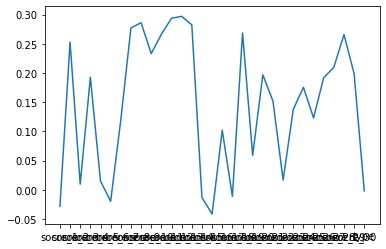

In [40]:
plt.plot(cor)

随机森林

-652.969696969697
-369.65511124467815
-356.5388422684899
-353.13341939057585
-347.56611175286474
-345.1654376943211
-343.69052110693065
-341.79234510518796
-342.20831447873337
-342.6612618981253
-341.69187387966724
-341.1466097123699
-341.1284867319033
-340.599431137195
-340.0446229999641
-340.6214336025973
-341.34999424190954
-340.15486663815625
-340.0187165932069
-339.8856669339889
最大得分：-339.8856669339889 子树数量为：191


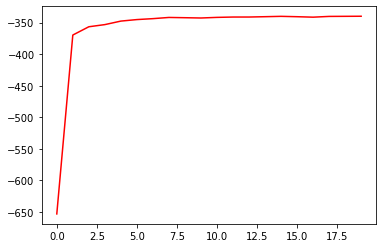

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

X = train_data.drop('total_score', axis=1)
X = X.drop(X.columns[l_cor], axis=1)
y = train_data['total_score']

# 选择子树数量
score_lt=[]
for i in range(0, 200, 10):
    regressor = RandomForestRegressor(n_estimators=i+1, random_state=42)
    cross_score = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error').mean()# 5折交叉验证
    print(cross_score)
    score_lt.append(cross_score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(0,20)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

调参

-652.969696969697
-525.3110606060607
-443.6548597081931
-415.81767676767674
-403.03877171717176
-393.7297194163861
-384.6380622552051
-370.02077335858587
-363.7012631999002
-366.55466682828285
-369.65511124467815
-367.6437083754209
-361.6032085709162
-359.4839168521955
-357.32008218181824
-361.4850760179924
-357.37784050190487
-356.16353356403545
-359.29924224516634
-357.0617181464646
最大得分：-356.16353356403545 子树数量为：18


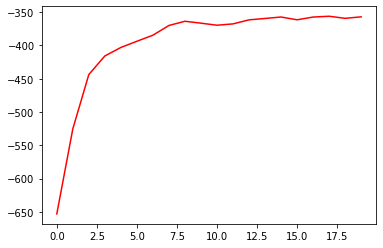

In [30]:
# 进一步缩小范围，选择子树数量
score_lt=[]
for i in range(0, 20):
    regressor = RandomForestRegressor(n_estimators=i+1, random_state=42)
    cross_score = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error').mean()#5折交叉验证
    print(cross_score)
    score_lt.append(cross_score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+1))

# 绘制学习曲线
x = np.arange(0,20)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [31]:
from sklearn.model_selection import GridSearchCV

# 网格搜索调参
param_grid = {
    'max_depth': range(1,20)
}

regressor = RandomForestRegressor(n_estimators=13, random_state=42)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

# 最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 2}
Best Score: -330.8334794281417


In [32]:
# 网格搜索调参
param_grid = {
    'min_samples_leaf': range(1,20)
}

regressor = RandomForestRegressor(n_estimators=13, random_state=42, max_depth=2)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

# 最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'min_samples_leaf': 14}
Best Score: -322.57716827321735


In [33]:
# 网格搜索调参
param_grid = {
    'max_features': range(5,31)
}

regressor = RandomForestRegressor(n_estimators=13, random_state=42, max_depth=2, min_samples_leaf=13)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_features': 14}
Best Score: -318.69968948386133


测试集拟合

In [34]:
regressor = RandomForestRegressor(n_estimators=13, random_state=42, max_depth=2, min_samples_leaf=13, max_features=7)
regressor.fit(X,y)

X_test = test_data.drop('total_score', axis=1)
X_test = X_test.drop(X_test.columns[l_cor], axis=1)
y_test = test_data['total_score']
y_pred = regressor.predict(X_test)

# 测试集上MSE
mse = mean_squared_error(y_test, y_pred)
print('测试集上的MSE是'+'{}'.format(mse))

# 测试集误差均值及方差
err = y_test-y_pred
err_mean = err.mean()
err_var = err.var()
print('测试样本误差的均值是'+'{}'.format(err_mean)+'方差是'+'{}'.format(err_var))

测试集上的MSE是273.0589120968491
测试样本误差的均值是0.33066756221777693方差是274.95655320029414


AdaBoost

-371.5889888276048
-333.9140544893775
-350.91838240964944
-349.40012725963624
-360.60376207943966
-364.1949834978285
-365.3478076356233
-367.06500637086896
-366.06507396458153
-362.16714774775545
-362.8882497348036
-361.0728034626904
-361.73174099884017
-361.6685482014259
-361.07669066553893
-364.18249046133053
-362.62761164992946
-361.7461711679188
-361.1545920214026
-364.61503043377286
最大得分：-333.9140544893775 子树数量为：11


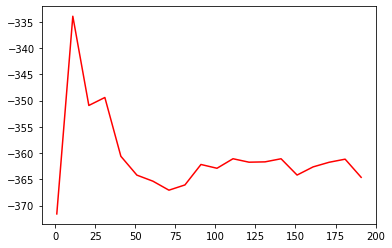

In [19]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

X = train_data.drop('total_score', axis=1)
X = X.drop(X.columns[l_cor], axis=1)
y = train_data['total_score']

# 选择子树数量
score_lt=[]
for i in range(0,200,10):
    regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=i+1, random_state=42, loss = 'square')# 基于上随机森林调参，选择max_depth为2
    cross_score = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    print(cross_score)
    score_lt.append(cross_score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,200,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

调参

-371.5889888276048
-372.20797033548376
-354.932074514373
-369.6369483227518
-357.6952841768748
-344.95510324682976
-343.0651784724156
-337.83897031414875
-333.1369105882869
-333.0197252878606
-333.9140544893775
-330.0852586642542
-331.3288016304837
-329.5349220830677
-335.3195450463278
-332.8199601311876
-338.9931021939788
-341.03937260955075
-342.25944035913756
-354.6275600379673
最大得分：-329.5349220830677 子树数量为：14


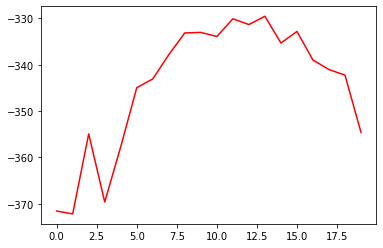

In [22]:
# 缩小范围，选择子树数量
score_lt=[]
for i in range(0,20):
    regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=i+1, random_state=42, loss = 'square')
    cross_score = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    print(cross_score)
    score_lt.append(cross_score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+1))

# 绘制学习曲线
x = np.arange(0,20)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV
# 网格搜索调参
param_grid = {
    'learning_rate': np.array(range(5,20))*0.1
}

regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=14, random_state=42, loss='square')
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

# 最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 1.0}
Best Score: -329.5349220830677


测试集拟合

In [71]:
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=14, random_state=42, loss='square', learning_rate=1.0)
regressor.fit(X,y)
X_test = test_data.drop('total_score', axis=1)
X_test = X_test.drop(X_test.columns[l_cor], axis=1)
y_test = test_data['total_score']
y_pred = regressor.predict(X_test)

# 测试集上MSE
mse = mean_squared_error(y_test, y_pred)
print('测试集上的MSE是'+'{}'.format(mse))

# 测试样本误差均值与方差
err = y_test-y_pred
err_mean = err.mean()
err_var = err.var()
print('测试样本误差的均值是'+'{}'.format(err_mean)+'方差是'+'{}'.format(err_var))

测试集上的MSE是262.398831118643
测试样本误差的均值是-1.3179683591485576方差是262.57842133559484
